In this notebook we explore two different models: the arima model and the Hidden markov model


We first import the neccessary packages:

In [45]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from itertools import product


Next, we pick up the data using the yahoo finance package and plot it 

[*********************100%%**********************]  1 of 1 completed


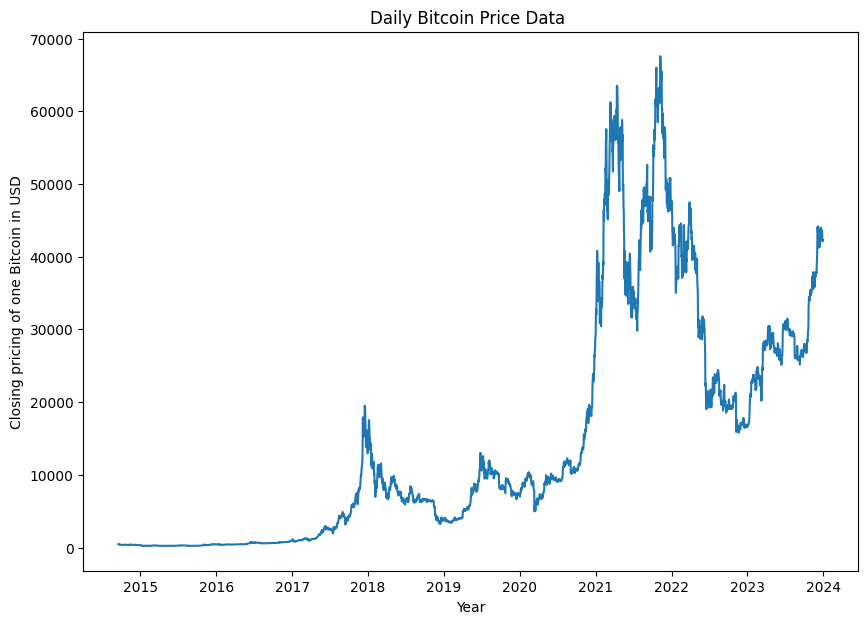

In [2]:
dfbit = yf.download(tickers='BTC-USD', start="2012-01-01", end="2024-01-01")
plt.figure(figsize=(10,7))
plt.xlabel('Year')
plt.ylabel("Closing pricing of one Bitcoin in USD")
plt.title("Daily Bitcoin Price Data ")
plt.plot(dfbit.index, dfbit['Close'])

Taking a look at the final 5 rows of the data..


In [20]:
dfbit.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055
2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344,42156.902344,16013925945
2023-12-31,42152.097656,42860.937500,41998.253906,42265.187500,42265.187500,16397498810


## Approach 1: ARIMA model


In [4]:

# We define a function that can split our training and testing data. It also has ratio as input since we don't want to use all of our data for hyperparameter tuning, only a percentage of it; the most recent percentage (in our case the 20% most recent

def train_test(X,r,perc_split):
    """
    :param X: is the input data
    :param r: the ratio of the data you want to split, useful for hyperparameter tuning
    :param perc_split: is the percentage of you split your train and test
    :return: 
    """
    ind = int(r*len(X.values))
    datanum = X.values[len(X.values)-ind:]
    size = int(r*len(X) * perc_split)
    traindat, testdat = datanum[0:size], datanum[size:len(X)]
    return traindat, testdat

# This function runs a forward evaluation of our arima model based on the train, test and parameters (order). It returns the rmse of the fitted arima model

def forwardval(train,test,order):
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        Armodel = ARIMA(history, order=order)
        Armodel.initialize_approximate_diffuse()
        model_fit = Armodel.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse
    
    

In [5]:
# We define a function that acts as our hyperparameter tuning, it looks at all the combinations and returns the best configuration with the best rmse score. We also added a keyboard interrupt option in case training would take too long,and we can interrupt it and still be able to have our best configuration (since we are doing random search).

def fitter(train,test,configs):
    best_score, best_cfg = float("inf"), None
    try:
        for combination in tqdm(configs, desc="Loading..."):
            p, d, q = combination
            order = (p, d, q)
            rmse=forwardval(train,test,order)
            if rmse < best_score:
                best_score, best_cfg = rmse, order
            print('ARIMA%s RMSE=%.3f' % (order, rmse))
        print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    except KeyboardInterrupt:
        print("Keyboard interrupt detected. Returning the best configuration found so far.")
    return best_cfg, best_score

We first take a look at the autocorrelation plot to get an idea for our hyperparameters:

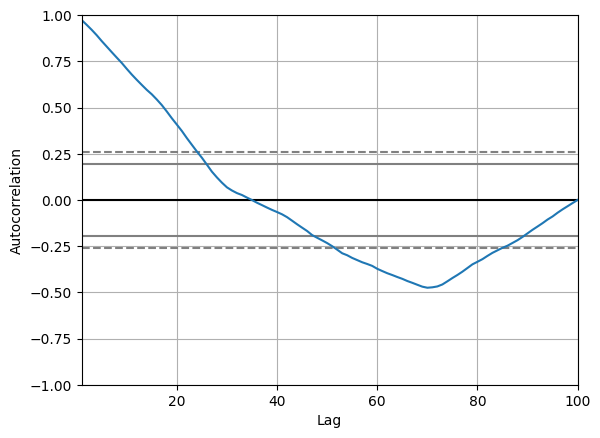

In [6]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

autocorrelation_plot(dfbit.Close[len(dfbit.Close)-100:])
pyplot.show()


We now initialize our list of parameters and shuffle them to perform random search

In [24]:
plist=[0,1,2,4,6]
# p is the number of lags, the higher this is, the more lags and training will take longer
dlist=[0,1,2,3]
#d; differencing, d is the order of differencing to make it stationary so that time series is stationary (so constant mean, variance etc.)
qlist=[0,1,2,3]
# q is the number of lagged forecast errors included in the prediction equation

# Generate all possible combinations of hyperparameters

combinations = list(product(plist, dlist, qlist,))

# Shuffle the list to ensure randomness
random.shuffle(combinations)


Running the random search:

In [8]:
warnings.filterwarnings("ignore")

train, test = train_test(dfbit.Close,0.2,0.70)

best_cfg, best_score = fitter(train,test,combinations)

# Extract the best configuration
print("Best configuration:", best_cfg)
print("Best RMSE:", best_score)

Loading...:   0%|          | 0/80 [00:00<?, ?it/s]

ARIMA(2, 1, 2) RMSE=673.045
ARIMA(0, 3, 2) RMSE=701.399
ARIMA(1, 1, 3) RMSE=673.218
ARIMA(1, 0, 0) RMSE=672.923
ARIMA(6, 3, 2) RMSE=758.648
ARIMA(1, 1, 0) RMSE=673.162
ARIMA(0, 2, 1) RMSE=677.757
ARIMA(4, 0, 2) RMSE=678.698
ARIMA(1, 2, 3) RMSE=671.668
ARIMA(4, 1, 1) RMSE=674.121
ARIMA(2, 1, 3) RMSE=672.974
ARIMA(6, 0, 2) RMSE=684.096
ARIMA(6, 0, 0) RMSE=681.668
ARIMA(1, 3, 1) RMSE=816.227
ARIMA(4, 3, 1) RMSE=743.555
ARIMA(1, 3, 2) RMSE=703.077
ARIMA(6, 2, 2) RMSE=689.137
ARIMA(4, 1, 3) RMSE=676.253
ARIMA(6, 3, 3) RMSE=702.674
ARIMA(0, 0, 0) RMSE=9070.836
ARIMA(6, 1, 2) RMSE=690.952
ARIMA(2, 2, 0) RMSE=783.701
ARIMA(0, 2, 0) RMSE=969.686
ARIMA(4, 2, 2) RMSE=673.498
ARIMA(2, 3, 1) RMSE=769.115
ARIMA(1, 2, 1) RMSE=687.612
ARIMA(2, 1, 0) RMSE=672.459
ARIMA(1, 0, 1) RMSE=679.764
ARIMA(1, 3, 3) RMSE=671.255
ARIMA(0, 1, 2) RMSE=673.091
ARIMA(0, 1, 1) RMSE=673.451
ARIMA(2, 0, 1) RMSE=678.737
ARIMA(4, 3, 0) RMSE=911.978
ARIMA(0, 3, 1) RMSE=970.569
ARIMA(4, 3, 3) RMSE=696.964
ARIMA(2, 2, 2) RMSE

In [7]:
#Now we train our actual model with the best configuration

warnings.filterwarnings("ignore")
train,test = train_test(dfbit.Close,1,0.70)
best_cfg=(2,2,3)

history = [x for x in train]
predictions = list()
for t in tqdm(range(len(test)),desc='Fitting...'):
    Armodel = ARIMA(history, order=best_cfg)
    Armodel.initialize_approximate_diffuse()
    model_fit = Armodel.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)



Fitting...:   0%|          | 0/1018 [00:00<?, ?it/s]

Now we evaluate our predictions for 500 days, 100 days, and the full length of the test set (1018 days)

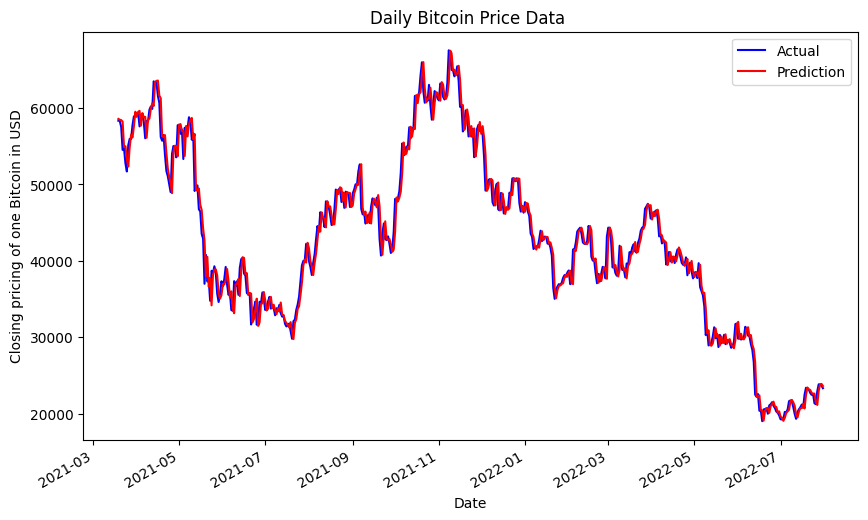

Test RMSE: 1629.953


In [44]:
# plot forecasts against actual outcomes based on the prediction days
pred_days=500
days = dfbit.index[-len(test):]
plt.figure(figsize=(10,6))
plt.gca().figure.autofmt_xdate()
plt.plot(days[:pred_days],test[:pred_days],'b')
plt.plot(days[:pred_days],predictions[:pred_days], 'r')
plt.xlabel('Date')
plt.ylabel("Closing pricing of one Bitcoin in USD")
plt.title("Daily Bitcoin Price Data ")
plt.legend(['Actual','Prediction'])
plt.show()
rmse = np.sqrt(mean_squared_error(test[:pred_days], predictions[:pred_days]))
print('Test RMSE: %.3f' % rmse)

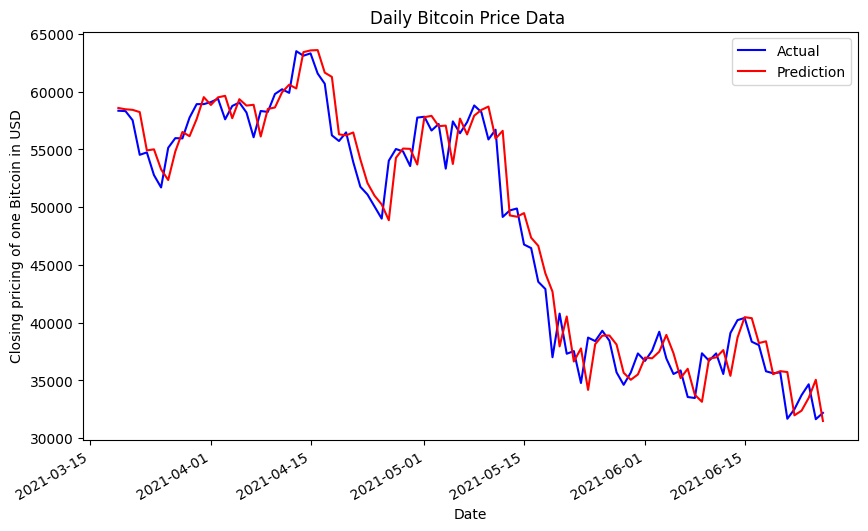

Test RMSE: 2162.417


In [26]:
# plot forecasts against actual outcomes based on the prediction days
pred_days=100
days = dfbit.index[-len(test):]
plt.figure(figsize=(10,6))
plt.gca().figure.autofmt_xdate()
plt.plot(days[:pred_days],test[:pred_days],'b')
plt.plot(days[:pred_days],predictions[:pred_days], 'r')
plt.xlabel('Date')
plt.ylabel("Closing pricing of one Bitcoin in USD")
plt.title("Daily Bitcoin Price Data ")
plt.legend(['Actual','Prediction'])
plt.show()
rmse = np.sqrt(mean_squared_error(test[:pred_days], predictions[:pred_days]))
print('Test RMSE: %.3f' % rmse)

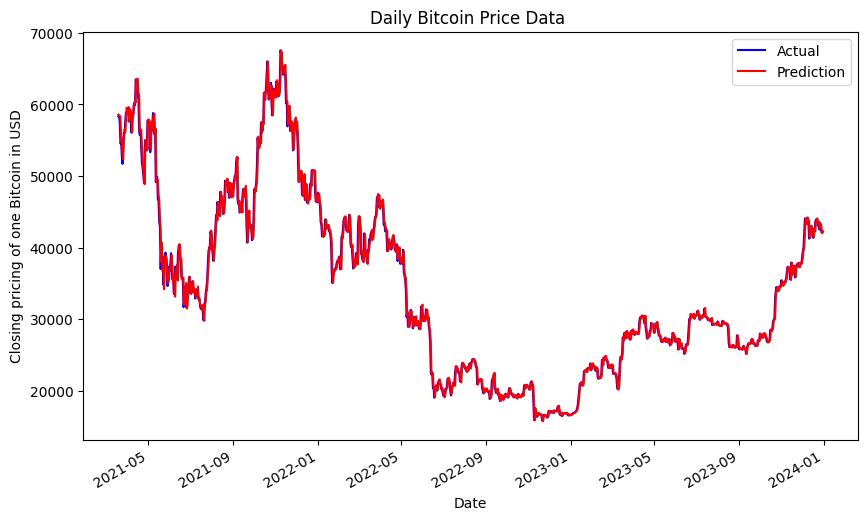

Test RMSE: 1227.626


In [43]:
# plot forecasts against actual outcomes based on the prediction days
pred_days=len(test)
days = dfbit.index[-len(test):]
plt.figure(figsize=(10,6))
plt.gca().figure.autofmt_xdate()
plt.plot(days[:pred_days],test[:pred_days],'b')
plt.plot(days[:pred_days],predictions[:pred_days], 'r')
plt.xlabel('Date')
plt.ylabel("Closing pricing of one Bitcoin in USD")
plt.title("Daily Bitcoin Price Data ")
plt.legend(['Actual','Prediction'])
plt.show()
rmse = np.sqrt(mean_squared_error(test[:pred_days], predictions[:pred_days]))
print('Test RMSE: %.3f' % rmse)

Looks like just one day lag, in this case its a one step forecast; can only forecast one day in advance given the last x days 

We can take a specific look at the parameters of our model, as well as our residuals to check that they are normally distributed 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3391
Model:                 ARIMA(2, 2, 3)   Log Likelihood              -27372.189
Date:                Fri, 05 Apr 2024   AIC                          54756.379
Time:                        15:57:17   BIC                          54793.149
Sample:                             0   HQIC                         54769.523
                               - 3391                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9030      0.007   -277.233      0.000      -1.916      -1.890
ar.L2         -0.9713      0.007   -137.938      0.000      -0.985      -0.958
ma.L1          0.8831      0.013     68.054      0.0

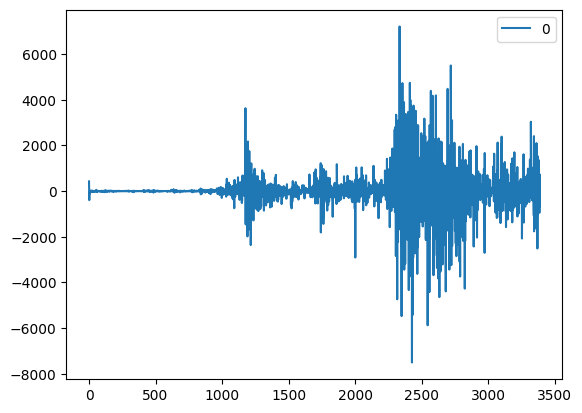

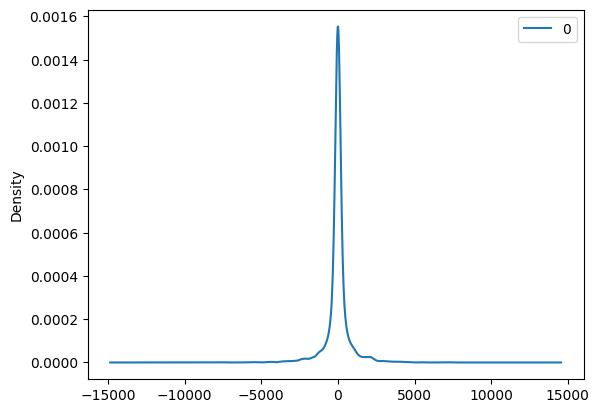

                 0
count  3391.000000
mean      6.132487
std     777.252138
min   -7503.667720
25%     -95.303329
50%       0.795893
75%      99.280953
max    7206.986796


In [10]:
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

## Approach 2: HMM model

We follow a similar approach as in the paper, and extract three different features; frac_change,frac_high and frac_low
Our aim is to predict the closing price of bitcoin of one day using the opening price and price of the past days

We first import all hmm related packages:

In [11]:
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
import logging
import itertools

Next we define all the function mentioned in the paper, with a few changes, since we want to return predicted prices as well as the RMSE score

In [12]:
%matplotlib inline

class StockPredictor(object):
    def __init__(self, stock_price, test_size=0.30,
                 n_hidden_states=4, n_latency_days=10,
                 n_steps_frac_change=20, n_steps_frac_high=20,
                 n_steps_frac_low=20):
        self._init_logger()

        self.data = stock_price
        self.n_latency_days = n_latency_days

        self.hmm = GaussianHMM(n_components=n_hidden_states)

        self._split_train_test_data(test_size)

        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)

    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)

    def _split_train_test_data(self, test_size):
        data = self.data
        _train_data, test_data = train_test_split(
            data, test_size=test_size, shuffle=False)

        self._train_data = _train_data
        self._test_data = test_data

    @staticmethod
    def _extract_features(data):
        open_price = np.array(data['Open'])
        close_price = np.array(data['Close'])
        high_price = np.array(data['High'])
        low_price = np.array(data['Low'])

        # Compute the fraction change in close, high and low prices
        # which would be used a feature
        frac_change = (close_price - open_price) / open_price
        frac_high = (high_price - open_price) / open_price
        frac_low = (open_price - low_price) / open_price

        return np.column_stack((frac_change, frac_high, frac_low))

    def fit(self):
        #self._logger.info('>>> Extracting Features')
        feature_vector = StockPredictor._extract_features(self._train_data)
        #self._logger.info('Features extraction Completed <<<')

        self.hmm.fit(feature_vector)

    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)

        self._possible_outcomes = np.array(list(itertools.product(
            frac_change_range, frac_high_range, frac_low_range)))

    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_start_index: previous_data_end_index]
        previous_data_features = StockPredictor._extract_features(
            previous_data)        

        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
        #print(np.argmax(outcome_score))

        #print(most_probable_outcome)
        
        return most_probable_outcome

    def predict_close_price(self, day_index):
        open_price = self._test_data.iloc[day_index]['Open']
        predicted_frac_change, _, _ = self._get_most_probable_outcome(day_index)
        return open_price * (1 + predicted_frac_change)

    def predict_close_prices_for_days(self, days, with_plot=False):
        predicted_close_prices = []
        for day_index in tqdm(range(days)):
            predicted_close_prices.append(self.predict_close_price(day_index))
            
        test_data = self._test_data[0: days]
        days = np.array(test_data.index, dtype='datetime64[ms]')
        actual_close_prices = test_data['Close']

        if with_plot:
            

            fig = plt.figure(figsize=(10,6))

            axes = fig.add_subplot(111)
            axes.plot(days, actual_close_prices, 'b', label='actual')
            axes.plot(days, predicted_close_prices, 'r', label='predicted')

            fig.autofmt_xdate()
            plt.legend()
            plt.xlabel('Date')
            plt.ylabel("Closing pricing of one Bitcoin in USD")
            plt.title("Daily Bitcoin Price Data ")
            plt.show()
            
        RMSE = np.sqrt(1/np.size(actual_close_prices)*np.linalg.norm(actual_close_prices-predicted_close_prices, ord=2)**2)

        return predicted_close_prices, RMSE


We again initialize a list of different hyperparameters and shuffle them to prepare for random search hyperparameter tuning:

In [19]:
ndays=[10,20,30,40,50]
h_states=[2,4,6,8,10]

combinations = list(product(ndays ,h_states))

# Shuffle the list to ensure randomness
random.shuffle(combinations)


Next we run random search with a prediction window of fifty days so that it won't run too long

In [20]:
warnings.filterwarnings('ignore')
best_score, best_cfg = float("inf"),None
for cfg in tqdm(combinations,desc='Tuning...'):
    n,hs=cfg
    stock_predictor = StockPredictor(dfbit,n_latency_days=n, n_hidden_states=hs)
    stock_predictor.fit()
    forecasts, rmse =stock_predictor.predict_close_prices_for_days(50, with_plot=False)
    if rmse < best_score:
        best_score, best_cfg = rmse, cfg
    print('GHMM%s RMSE=%.3f' % (cfg, rmse))
print('Best GHMM%s RMSE=%.3f' % (best_cfg, best_score))
   


Tuning...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(30, 2) RMSE=1969.936


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(10, 8) RMSE=2261.704


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(40, 4) RMSE=2067.487


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(50, 8) RMSE=2108.095


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(40, 6) RMSE=2133.909


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(30, 8) RMSE=2520.388


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(20, 2) RMSE=2092.004


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(40, 10) RMSE=2261.568


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(50, 2) RMSE=2008.906


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(50, 6) RMSE=2050.543


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(40, 8) RMSE=2113.628


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(50, 4) RMSE=2104.147


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(40, 2) RMSE=2135.197


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(20, 6) RMSE=2104.058


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(20, 10) RMSE=2088.814


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(20, 8) RMSE=2041.621


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(50, 10) RMSE=2226.490


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(30, 10) RMSE=1989.320


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(10, 4) RMSE=2269.077


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(10, 6) RMSE=2210.938


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(30, 4) RMSE=2052.886


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(20, 4) RMSE=2121.053


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(10, 2) RMSE=2092.004


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(30, 6) RMSE=2315.253


  0%|          | 0/50 [00:00<?, ?it/s]

GHMM(10, 10) RMSE=2067.487
Best GHMM(30, 2) RMSE=1969.936


Now we use our best configuration to train our final model 

  0%|          | 0/500 [00:00<?, ?it/s]

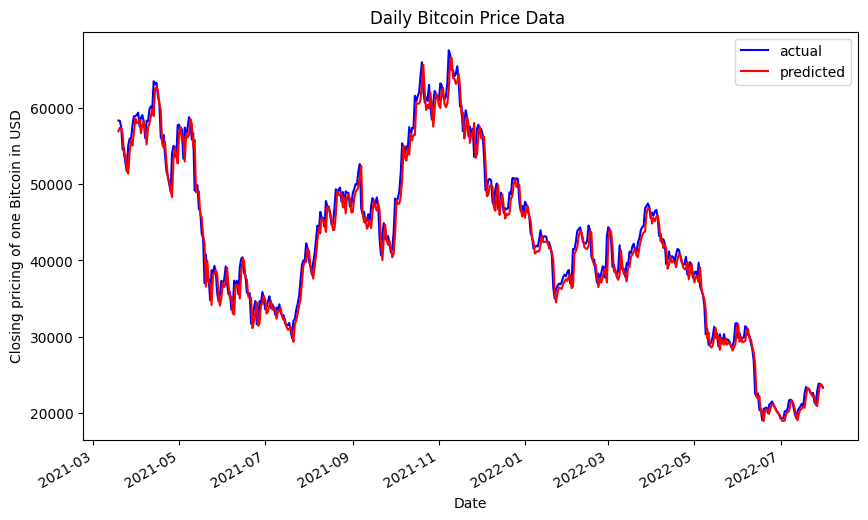

Test RMSE:  1701.5375095873678


In [22]:
warnings.filterwarnings('ignore')

# Change plot style to ggplot (for better and more aesthetic visualisation)

stock_predictor = StockPredictor(dfbit,n_latency_days=30, n_hidden_states=2)
stock_predictor.fit()
forecasts,RMSE=stock_predictor.predict_close_prices_for_days(500, with_plot=True)
print("Test RMSE: ", RMSE)

  0%|          | 0/100 [00:00<?, ?it/s]

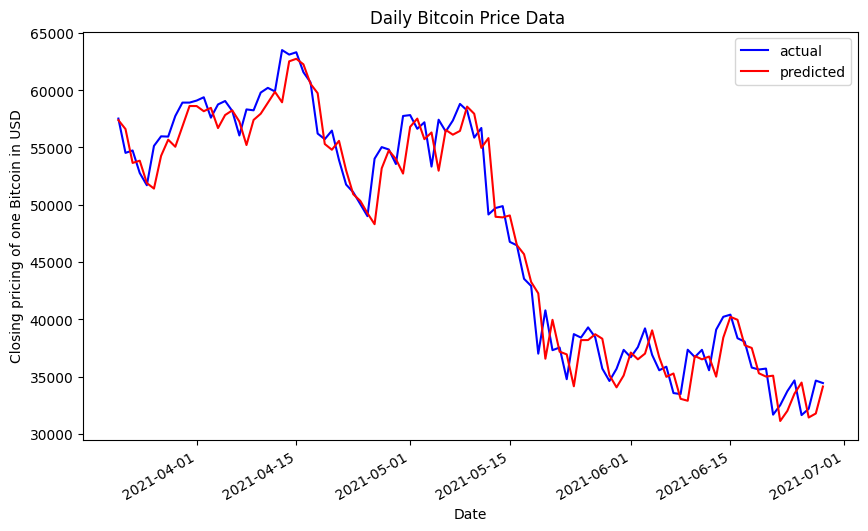

Test RMSE:  2145.8000750524925


In [36]:
warnings.filterwarnings('ignore')

# Change plot style to ggplot (for better and more aesthetic visualisation)

stock_predictor = StockPredictor(dfbit,n_latency_days=30, n_hidden_states=2)
stock_predictor.fit()
forecasts,RMSE=stock_predictor.predict_close_prices_for_days(100, with_plot=True)
print("Test RMSE: ", RMSE)

  0%|          | 0/1016 [00:00<?, ?it/s]

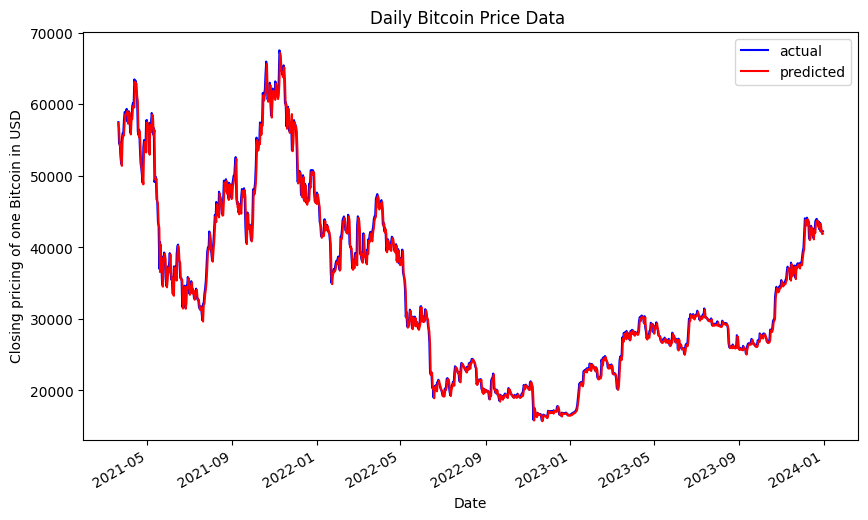

Test RMSE:  1227.7398759281723


In [41]:
warnings.filterwarnings('ignore')

# Change plot style to ggplot (for better and more aesthetic visualisation)

stock_predictor = StockPredictor(dfbit,n_latency_days=30, n_hidden_states=2)
stock_predictor.fit()
#Note that we cannot predict the full test due to the condition on the number of latency days, we therefore find the maximum amount of predictions as: 
length=1016
forecasts,RMSE=stock_predictor.predict_close_prices_for_days(length, with_plot=True)
print("Test RMSE: ", RMSE)

## Bonus Model: Forecasting using one day lag

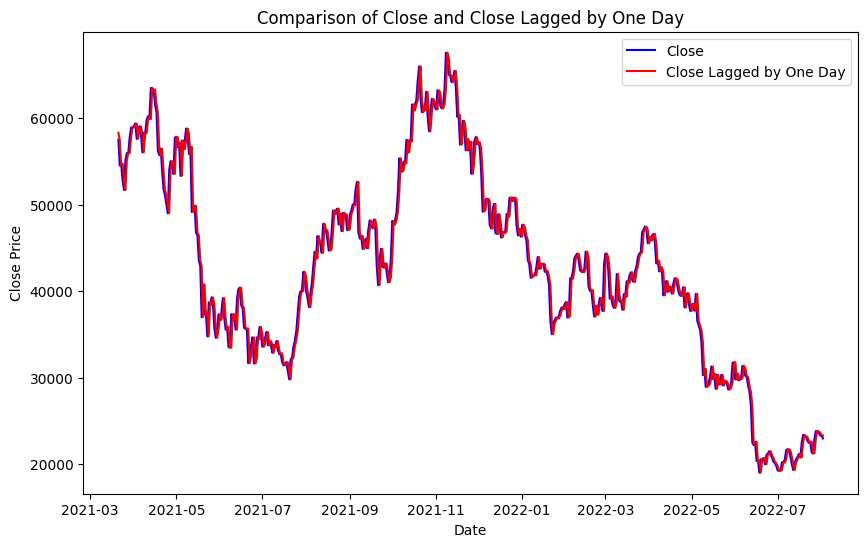

Root Mean Squared Error (RMSE): 1612.4357375534435


In [34]:
# We Make a column to represent one day lag and drop Nan's
dfbit['Close_Lagged'] = dfbit['Close'].shift(1)
dfbit.dropna(inplace=True)

# We want to compare it to our actual models, so we "train" it as if it had a 70-30 train test split:

# Calculate the index where the last 30% of the data starts
last_30_percent_index = int(0.7 * len(dfbit))

# Slice the DataFrame to get the last 30% of the data
last_30_percent_df = dfbit.iloc[last_30_percent_index:]

pred_days=500
# Calculate mean squared error between 'Close' and 'Close_Lagged' for the last 30% of the data
mse_last_30_percent = mean_squared_error(last_30_percent_df['Close'][:pred_days], last_30_percent_df['Close_Lagged'][:pred_days])

# Calculate root mean squared error (RMSE) for the last 30% of the data



# Plot both 'Close' and 'Close_Lagged' columns
plt.figure(figsize=(10, 6))
plt.plot(last_30_percent_df['Close'][:pred_days], label='Close', color='blue')
plt.plot(last_30_percent_df['Close_Lagged'][:pred_days], label='Close Lagged by One Day', color='red')


# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Comparison of Close and Close Lagged by One Day')
plt.legend()

# Show plot
plt.show()
print("Root Mean Squared Error (RMSE):", rmse)


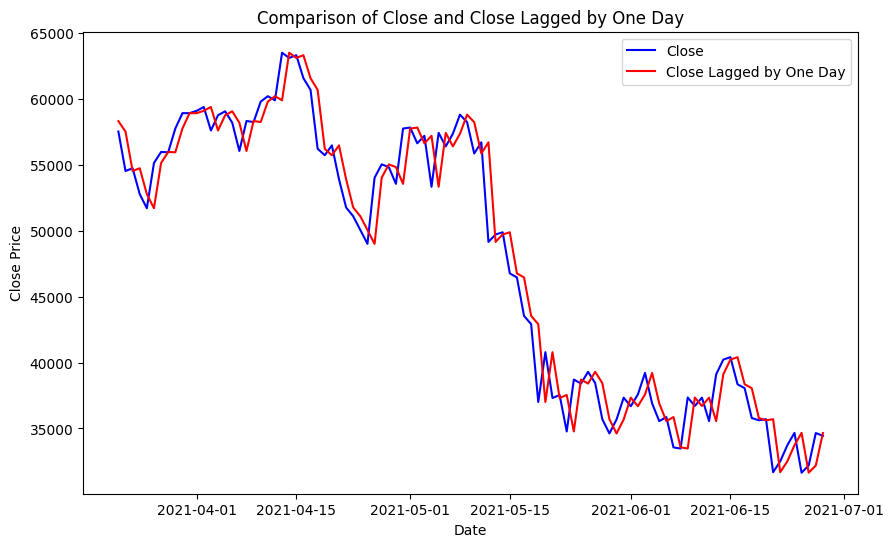

Root Mean Squared Error (RMSE): 2143.0116642676626


In [35]:
pred_days=100

mse_last_30_percent = mean_squared_error(last_30_percent_df['Close'][:pred_days], last_30_percent_df['Close_Lagged'][:pred_days])

# Calculate root mean squared error (RMSE) for the last 30% of the data
rmse = np.sqrt(mse_last_30_percent)



# Plot both 'Close' and 'Close_Lagged' columns
plt.figure(figsize=(10, 6))
plt.plot(last_30_percent_df['Close'][:pred_days], label='Close', color='blue')
plt.plot(last_30_percent_df['Close_Lagged'][:pred_days], label='Close Lagged by One Day', color='red')


# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Comparison of Close and Close Lagged by One Day')
plt.legend()

# Show plot
plt.show()
print("Root Mean Squared Error (RMSE):", rmse)


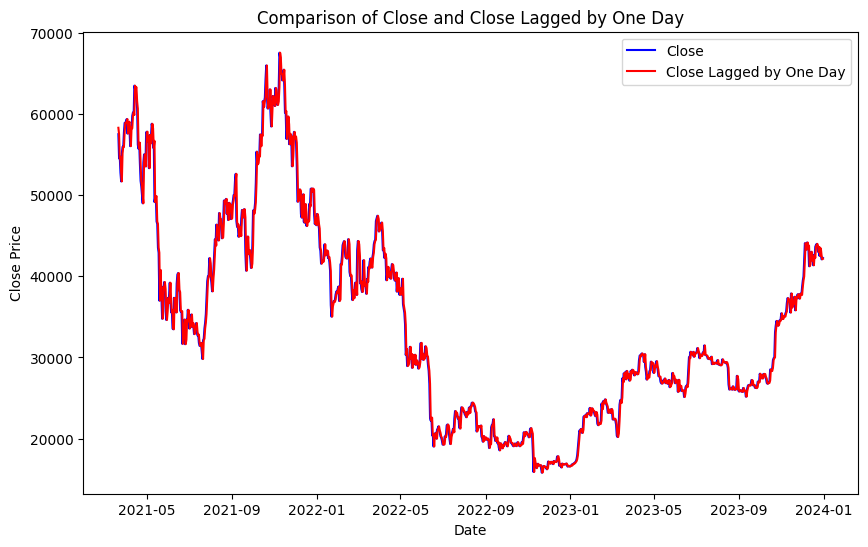

Root Mean Squared Error (RMSE): 1216.724070216263


In [42]:
pred_days = len(test)

mse_last_30_percent = mean_squared_error(last_30_percent_df['Close'][:pred_days],
                                         last_30_percent_df['Close_Lagged'][:pred_days])

# Calculate root mean squared error (RMSE) for the last 30% of the data
rmse = np.sqrt(mse_last_30_percent)

# Plot both 'Close' and 'Close_Lagged' columns
plt.figure(figsize=(10, 6))
plt.plot(last_30_percent_df['Close'][:pred_days], label='Close', color='blue')
plt.plot(last_30_percent_df['Close_Lagged'][:pred_days], label='Close Lagged by One Day', color='red')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Comparison of Close and Close Lagged by One Day')
plt.legend()

# Show plot
plt.show()
print("Root Mean Squared Error (RMSE):", rmse)